<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/RNN_Live_Session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Teacher Forcing
=============================
Pedagogical demonstration focusing on teacher forcing in seq2seq models

Topics covered:
1. Seq2Seq architecture (hello → world)
2. Training WITHOUT teacher forcing (exposure to own predictions)
3. Training WITH teacher forcing (using ground truth)
4. Exposure bias problem
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# UTILITY FUNCTIONS (Preamble)
# ============================================================================

def plot_training_comparison(losses_with_tf, losses_without_tf):
    """Visualize the difference between training with/without teacher forcing"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(losses_with_tf, label='With Teacher Forcing', linewidth=2.5, color='green', alpha=0.8)
    ax.plot(losses_without_tf, label='Without Teacher Forcing', linewidth=2.5, color='red', alpha=0.8, linestyle='--')
    ax.set_xlabel('Training Steps', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_title('Training Stability: Teacher Forcing vs Autoregressive', fontsize=16, fontweight='bold')
    ax.legend(fontsize=13, loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_exposure_bias():
    """Create a conceptual diagram of exposure bias"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Training scenario
    steps = np.arange(5)
    perfect_context = np.ones(5)
    bars1 = ax1.bar(steps, perfect_context, color='green', alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylim([0, 1.3])
    ax1.set_xlabel('Decoder Time Step', fontsize=13)
    ax1.set_ylabel('Input Quality', fontsize=13)
    ax1.set_title('TRAINING: Always Ground Truth\n(Teacher Forcing)', fontsize=14, fontweight='bold')
    ax1.set_xticks(steps)
    ax1.set_xticklabels([f't={i}' for i in steps])
    ax1.axhline(y=1.0, color='green', linestyle=':', linewidth=2, alpha=0.5)
    ax1.text(2, 1.15, 'Perfect inputs every step', ha='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    ax1.grid(True, axis='y', alpha=0.3)

    # Inference scenario (with error accumulation)
    inference_quality = np.array([1.0, 0.95, 0.85, 0.70, 0.50])
    bars2 = ax2.bar(steps, inference_quality, color='red', alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylim([0, 1.3])
    ax2.set_xlabel('Decoder Time Step', fontsize=13)
    ax2.set_ylabel('Input Quality', fontsize=13)
    ax2.set_title('INFERENCE: Model Own Predictions\n(Error Accumulation)', fontsize=14, fontweight='bold')
    ax2.set_xticks(steps)
    ax2.set_xticklabels([f't={i}' for i in steps])

    # Add arrows showing degradation
    for i in range(len(steps)-1):
        ax2.annotate('', xy=(steps[i+1], inference_quality[i+1]),
                    xytext=(steps[i], inference_quality[i]),
                    arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

    ax2.text(2, 1.15, 'Errors accumulate over time', ha='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    ax2.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
# ============================================================================
# LIVE CODING DEMONSTRATION
# ============================================================================

print("=" * 80)
print(" " * 20 + "RNN LECTURE: TEACHER FORCING")
print("=" * 80)

# Create vocabulary
vocab = ['<PAD>', '<START>', '<END>', 'h', 'e', 'l', 'o', 'w', 'r', 'd',
         'a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'j']
char_to_idx = {c: i for i, c in enumerate(vocab)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

print(f"\nVocabulary: {vocab}")
print(f"Vocab size: {len(vocab)}")

# ============================================================================
# Setup: "hello" → "world" Seq2Seq Task
# ============================================================================

print("\n" + "=" * 80)
print("TASK: SEQUENCE-TO-SEQUENCE TRANSLATION")
print("=" * 80)

src_text = "hello"
tgt_text = "world"

print(f"\nSource sequence: '{src_text}'")
print(f"Target sequence: '{tgt_text}'")
print("\nThis is a many-to-many task (encoder-decoder architecture)")

# Prepare data
src_tokens = [char_to_idx['<START>']] + [char_to_idx[c] for c in src_text] + [char_to_idx['<END>']]
tgt_tokens = [char_to_idx['<START>']] + [char_to_idx[c] for c in tgt_text] + [char_to_idx['<END>']]

src_tensor = torch.tensor([src_tokens])
tgt_tensor = torch.tensor([tgt_tokens])

print(f"\nTokenized source: {src_tokens}")
print(f"  → {[idx_to_char[i] for i in src_tokens]}")
print(f"\nTokenized target: {tgt_tokens}")
print(f"  → {[idx_to_char[i] for i in tgt_tokens]}")

                    RNN LECTURE: TEACHER FORCING

Vocabulary: ['<PAD>', '<START>', '<END>', 'h', 'e', 'l', 'o', 'w', 'r', 'd', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'j']
Vocab size: 19

TASK: SEQUENCE-TO-SEQUENCE TRANSLATION

Source sequence: 'hello'
Target sequence: 'world'

This is a many-to-many task (encoder-decoder architecture)

Tokenized source: [1, 3, 14, 5, 5, 6, 2]
  → ['<START>', 'h', 'e', 'l', 'l', 'o', '<END>']

Tokenized target: [1, 7, 6, 8, 5, 13, 2]
  → ['<START>', 'w', 'o', 'r', 'l', 'd', '<END>']



# Teacher Forcing in Recurrent Neural Networks
We'll compare the universal RNN architecture with the teacher forcing variant and understand why this trade-off is often worthwhile.

**Important:** "Efficiency" is not always about parallel computation, but about more stable gradients and simplified training procedures.

---

## 1. Universal RNN Architecture (Baseline)
In a standard **universal RNN**, the recurrence flows through the hidden states:

```
x(t-1) → h(t-1) → o(t-1)
           ↓
x(t)   → h(t)   → o(t)
           ↓
x(t+1) → h(t+1) → o(t+1)
```

### Why "Universal"?

The universal RNN can encode **arbitrary history information** in the hidden state `h(t)`. The hidden state is:
- Not directly constrained by the loss function
- Free to represent any function of the past
- Can act as a flexible memory

---

## 2. RNN with Output Feedback (Teacher Forcing Architecture)

Instead of feeding `h(t-1)` back to `h(t)`, we feed **`o(t-1)` back to `h(t)`**:

This architecture is **strictly less powerful** than the universal RNN because:

1. **Constrained Information Flow**: The only information from the past comes through `o(t-1)`
2. **Loss Function Constraint**: Since we want `o(t)` ≈ `y(t)` (the target), the output must resemble the labels
3. **Limited Expressiveness**: We cannot put arbitrary history information into `o(t)` - it must be a valid prediction

**Key insight:** `o(t)` serves two conflicting purposes:
- Must be a good prediction (close to `y(t)`)
- Must encode history information for future predictions

This dual role limits what information can be stored!

---

## 3. The Power of Teacher Forcing (Pure Architecture)

### Training Time Advantage

During **training**, we have access to the ground truth labels `y(t-1)` (gold tokens). We can substitute:

**Instead of:** `o(t-1)` → `h(t)`  
**Use:** `y(t-1)` → `h(t)`

### Key Benefit: True Temporal Independence

Since there's **no h(t-1) dependency**, each `h(t)` only depends on the inputs `x(t)` and `y(t-1)` - both available from our dataset!

```
Time step t-1: x(t-1), y(t-2) → h(t-1) → o(t-1) → L(o(t-1), y(t-1))
Time step t:   x(t),   y(t-1) → h(t)   → o(t)   → L(o(t), y(t))
Time step t+1: x(t+1), y(t)   → h(t+1) → o(t+1) → L(o(t+1), y(t+1))
```

**Each time step is truly independent - can compute all h(t) in parallel!**

### Computational Comparison (Pure TF Architecture)

| Aspect | Universal RNN (BPTT) | Pure Teacher Forcing |
|--------|---------------------|---------------------|
| Hidden state recurrence? | ✓ h(t-1) → h(t) | ✗ None |
| Time steps coupled? | ✓ Yes (through h) | ✗ No (independent) |
| Training method | Backprop Through Time | Standard Backprop |
| Memory complexity | O(T) for sequence length T | O(1) per step |
| Parallelizable? | ✗ Sequential | ✓ Fully parallel |
| Gradient flow | Through long chains | Independent |

---

## 4. Reality Check: Seq2Seq with Hidden Recurrence

### The Standard Seq2Seq Architecture

In practice, most seq2seq models (including our "hello" → "world" example) use **both**:
- Hidden state recurrence: `h(t-1) → h(t)`
- Teacher forcing: ground truth `y(t-1)` as input during training

### Standard Encoder-Decoder Equations

**Encoder (always sequential):**
```
h_enc(t) = f_enc(x(t), h_enc(t-1))    # Must compute sequentially
context = h_enc(final)                 # Final hidden state
```

**Decoder (standard - still has hidden recurrence):**
```
h_dec(t) = f_dec(y(t-1), h_dec(t-1), context)    # Still sequential!
o(t) = g(h_dec(t))
```

**Decoder (pure TF - no hidden recurrence):**
```
h_dec(t) = f_dec(y(t-1), context)     # No h_dec(t-1) - can parallelize
o(t) = g(h_dec(t))
```

---

## 5. Example: "hello" → "world" (Seq2Seq)

### Task Setup

- **Source:** "hello" (5 characters)
- **Target:** "world" (5 characters)
- **Architecture:** Encoder-decoder with attention (or simple context vector)

### Step-by-Step Breakdown

#### Phase 1: Encoding (ALWAYS Sequential)

```
h_enc(0) = 0                                    # Initial state
h_enc(1) = f_enc(x="h", h_enc(0))              # Process 'h'
h_enc(2) = f_enc(x="e", h_enc(1))              # Process 'e'  
h_enc(3) = f_enc(x="l", h_enc(2))              # Process 'l'
h_enc(4) = f_enc(x="l", h_enc(3))              # Process 'l'
h_enc(5) = f_enc(x="o", h_enc(4))              # Process 'o'

context = h_enc(5)                              # Final encoding
```

**Cannot parallelize** - each step depends on previous hidden state.

#### Phase 2: Decoding with Teacher Forcing (Training)

```
# Decoder inputs: <START>, "w", "o", "r", "l"
# Targets:       "w",      "o", "r", "l", "d"

h_dec(0) = context                              # Initialize from encoder

# Standard decoder (with hidden recurrence):
h_dec(1) = f_dec(y(0)="<START>", h_dec(0), context)  # Predict "w"
h_dec(2) = f_dec(y(1)="w",       h_dec(1), context)  # Predict "o"
h_dec(3) = f_dec(y(2)="o",       h_dec(2), context)  # Predict "r"
h_dec(4) = f_dec(y(3)="r",       h_dec(3), context)  # Predict "l"
h_dec(5) = f_dec(y(4)="l",       h_dec(4), context)  # Predict "d"
```

**Still sequential** because of `h_dec(t-1) → h_dec(t)`!

#### Phase 2 Alternative: Pure TF Decoder (No Hidden Recurrence)

```
# If we remove hidden state recurrence:
h_dec(1) = f_dec(y(0)="<START>", context)     # Predict "w"
h_dec(2) = f_dec(y(1)="w",       context)     # Predict "o"
h_dec(3) = f_dec(y(2)="o",       context)     # Predict "r"
h_dec(4) = f_dec(y(3)="r",       context)     # Predict "l"
h_dec(5) = f_dec(y(4)="l",       context)     # Predict "d"
```

**Now parallelizable** - all h_dec(t) only depend on inputs and context!

**Key difference:** We use `inputs[t]` (ground truth) instead of sampled predictions, which:
- ✅ Provides stable training signal
- ✅ Prevents error accumulation during training
- ✅ Simplifies gradient computation
- ❌ But still sequential if h_dec depends on h_dec(t-1)


```
TRAINING (hello → world):
  Encoder: h→e→l→l→o → [context]
  Decoder: [context] + <START> → h_dec(0) → predict "w"
           [context] + "w"     → h_dec(1) → predict "o"  ← ground truth!
           [context] + "o"     → h_dec(2) → predict "r"  ← ground truth!
           ...

INFERENCE (hello → ???):
  Encoder: h→e→l→l→o → [context]
  Decoder: [context] + <START> → h_dec(0) → predict "w"
           [context] + "w"     → h_dec(1) → predict "o"  ← model's guess
           [context] + "o"     → h_dec(2) → predict "r"  ← model's guess
           ...
           
  If early prediction is wrong, errors accumulate!
```


## Mitigation Strategies

### Scheduled Sampling

Gradually transition from teacher forcing to using model predictions:

```python
teacher_forcing_ratio = max(0.5, 1.0 - epoch / max_epochs)

for t in range(tgt_len):
    if random() < teacher_forcing_ratio:
        decoder_input = ground_truth[t-1]  # Teacher forcing
    else:
        decoder_input = model_output[t-1]  # Use prediction
        
    h_dec = decoder_cell(decoder_input, h_dec_prev, context)
    o = output_layer(h_dec)
```

### Curriculum Learning

Start with teacher forcing, progressively reduce:
- Early epochs: 100% teacher forcing (stable learning)
- Middle epochs: 50% teacher forcing (mixed exposure)
- Late epochs: 0% teacher forcing (realistic conditions)


In [ ]:

# ============================================================================
# SEQ2SEQ MODEL WITH CONFIGURABLE TEACHER FORCING
# ============================================================================

class Seq2SeqRNN(nn.Module):
    """
    Encoder-Decoder architecture for sequence-to-sequence learning.

    Architecture:
        Encoder: Processes input sequence → produces context vector
        Decoder: Generates output sequence conditioned on context
    """
    def __init__(self, vocab_size, hidden_size=128, embedding_dim=64):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Encoder
        self.encoder_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder_gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)

        # Decoder
        self.decoder_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.decoder_gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def encode(self, src):
        """
        Encode source sequence into context vector.

        Args:
            src: [batch, src_len]
        Returns:
            context: [1, batch, hidden_size]
        """
        embedded = self.encoder_embedding(src)
        _, context = self.encoder_gru(embedded)
        return context

    def decode_step(self, input_token, hidden):
        """
        Single decoder step.

        Args:
            input_token: [batch, 1]
            hidden: [1, batch, hidden_size]
        Returns:
            logits: [batch, 1, vocab_size]
            hidden: [1, batch, hidden_size]
        """
        embedded = self.decoder_embedding(input_token)
        output, hidden = self.decoder_gru(embedded, hidden)
        logits = self.output_layer(output)
        return logits, hidden

    def forward(self, src, tgt, teacher_forcing_ratio=1.0):
        """
        Forward pass with configurable teacher forcing.

        Args:
            src: [batch, src_len] - source sequence
            tgt: [batch, tgt_len] - target sequence
            teacher_forcing_ratio: probability of using ground truth (0.0 to 1.0)
                1.0 = always use ground truth (full teacher forcing)
                0.0 = always use model prediction (no teacher forcing)

        Returns:
            outputs: [batch, tgt_len, vocab_size] - logits for each position
        """
        batch_size = src.size(0)
        tgt_len = tgt.size(1)

        # Encode source sequence
        context = self.encode(src)

        # Initialize decoder
        hidden = context
        decoder_input = tgt[:, 0:1]  # Start with <START> token

        # Store outputs
        outputs = torch.zeros(batch_size, tgt_len, self.vocab_size)

        # Decode step by step
        for t in range(1, tgt_len):
            # Decode one step
            logits, hidden = self.decode_step(decoder_input, hidden)
            outputs[:, t, :] = logits.squeeze(1)

            # Teacher forcing decision
            use_teacher_forcing = (np.random.random() < teacher_forcing_ratio)

            if use_teacher_forcing:
                # Use ground truth from target sequence
                decoder_input = tgt[:, t:t+1]
            else:
                # Use model's own prediction
                decoder_input = logits.argmax(dim=-1)

        return outputs

In [ ]:



# ============================================================================
# EXPERIMENT 1: Training WITHOUT Teacher Forcing
# ============================================================================


model_no_tf = Seq2SeqRNN(vocab_size=len(vocab), hidden_size=64, embedding_dim=32)
optimizer_no_tf = torch.optim.Adam(model_no_tf.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])

losses_without_tf = []
print("\nTraining progress:")

for step in range(200):
    optimizer_no_tf.zero_grad()

    # Forward pass WITHOUT teacher forcing
    outputs = model_no_tf(src_tensor, tgt_tensor, teacher_forcing_ratio=0.0)

    # Compute loss
    loss = criterion(outputs.view(-1, len(vocab)), tgt_tensor.view(-1))

    # Backward pass
    loss.backward()
    optimizer_no_tf.step()

    losses_without_tf.append(loss.item())

    if step % 50 == 0:
        print(f"  Step {step:3d}: loss = {loss.item():.4f}")

print(f"\n✗ Final loss: {losses_without_tf[-1]:.4f}")


# ============================================================================
# EXPERIMENT 2: Training WITH Teacher Forcing
# ============================================================================


model_with_tf = Seq2SeqRNN(vocab_size=len(vocab), hidden_size=64, embedding_dim=32)
optimizer_with_tf = torch.optim.Adam(model_with_tf.parameters(), lr=0.01)

losses_with_tf = []
print("\nTraining progress:")

for step in range(200):
    optimizer_with_tf.zero_grad()

    # Forward pass WITH teacher forcing
    outputs = model_with_tf(src_tensor, tgt_tensor, teacher_forcing_ratio=1.0)

    # Compute loss
    loss = criterion(outputs.view(-1, len(vocab)), tgt_tensor.view(-1))

    # Backward pass
    loss.backward()
    optimizer_with_tf.step()

    losses_with_tf.append(loss.item())

    if step % 50 == 0:
        print(f"  Step {step:3d}: loss = {loss.item():.4f}")

print(f"\n✓ Final loss: {losses_with_tf[-1]:.4f}")
print("  Notice: Training is smooth and stable!")

# ============================================================================
# COMPARISON: Side-by-Side Results
# ============================================================================

improvement = losses_without_tf[-1] - losses_with_tf[-1]
print(f"\n>> Teacher forcing improved final loss by {improvement:.4f}")

print("\nVisualizing training curves...")
plot_training_comparison(losses_with_tf, losses_without_tf)

plot_exposure_bias()




Training progress:
  Step   0: loss = 2.8938
  Step  50: loss = 0.4226
  Step 100: loss = 0.4215
  Step 150: loss = 0.4212

✗ Final loss: 0.4211



Training progress:
  Step   0: loss = 2.9202
  Step  50: loss = 0.4210
  Step 100: loss = 0.4209
  Step 150: loss = 0.4208

✓ Final loss: 0.4208
  Notice: Training is smooth and stable!

>> Teacher forcing improved final loss by 0.0003

Visualizing training curves...


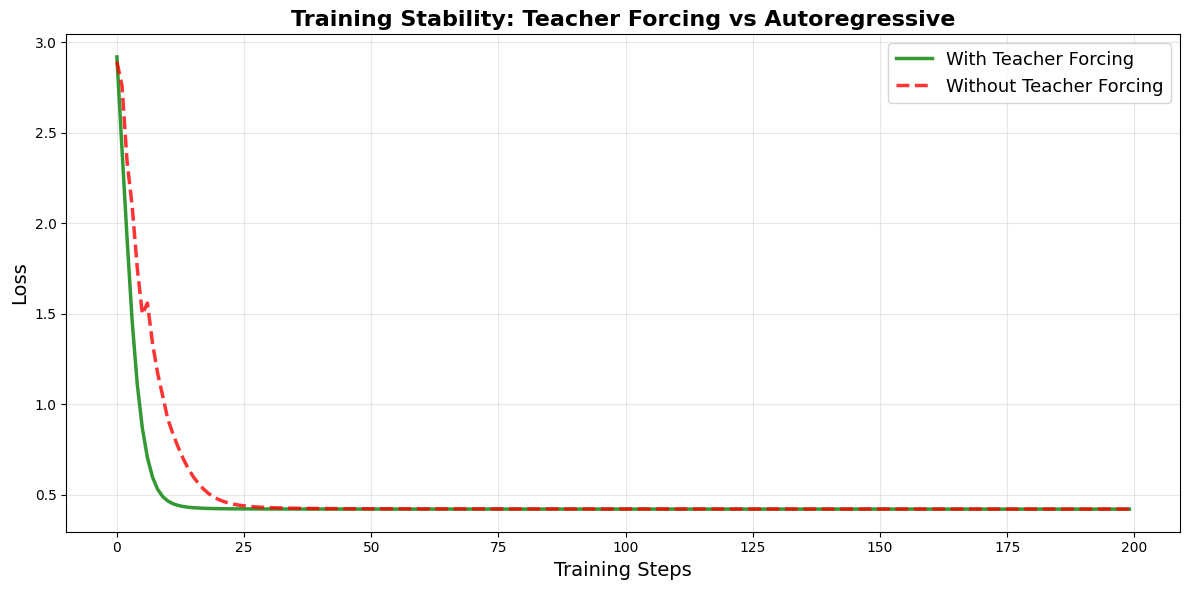

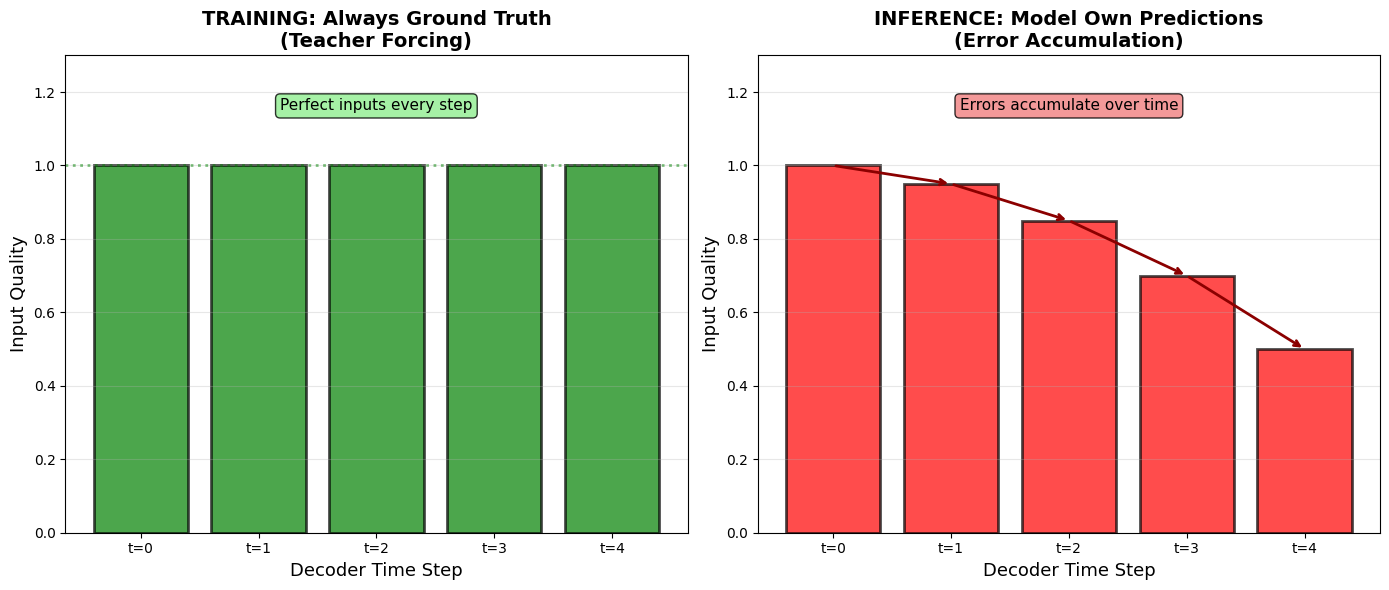


- **Teacher forcing:** Training strategy (use ground truth as input)
- **Beam search:** Inference strategy (how to generate output)

**At training time:**
- Use teacher forcing (decoder sees ground truth)
- No decoding needed (not generating)

**At inference time:**
- No teacher forcing available (no ground truth)
- Must use decoding strategy!



# Decoding Strategies: Greedy vs Beam Search

## Introduction

After training a seq2seq model with **teacher forcing**, we need a strategy to **generate sequences at inference time**. This is called **decoding** or **inference**.

The key question: **At each time step, how do we choose the next token?**

---

## The Decoding Problem

At inference time, the decoder produces a probability distribution over the vocabulary at each step:
```
Step 1: P(w₁ | context) → probability for each possible first word
Step 2: P(w₂ | w₁, context) → probability for each possible second word
Step 3: P(w₃ | w₁, w₂, context) → and so on...
```

**Goal:** Find the sequence that maximizes the total probability:
```
argmax P(w₁, w₂, ..., wₜ | context) = argmax ∏ P(wₜ | w₁...wₜ₋₁, context)
```

**Problem:** Exhaustive search over all possible sequences is **intractable**!
- Vocabulary size: V
- Sequence length: T
- Total sequences: V^T (exponential!)

We need **efficient approximation algorithms**.

---

## Strategy 1: Greedy Decoding

### How It Works

At each time step, pick the **single most likely token**:
```
w₁ = argmax P(w | context)
w₂ = argmax P(w | w₁, context)
w₃ = argmax P(w | w₁, w₂, context)
...
```

### Algorithm
```python
sequence = [<START>]
for t in range(max_length):
    probs = model.predict(sequence)
    next_token = argmax(probs)  # Pick highest probability
    sequence.append(next_token)
    if next_token == <END>:
        break
```

### Complexity

- **Time:** O(T × V) where T is sequence length, V is vocabulary size
- **Space:** O(T) - only store one sequence

### Advantages ✓

- **Fast:** Only one forward pass per time step
- **Simple:** Easy to implement
- **Memory efficient:** Only track one hypothesis

### Disadvantages ✗

- **Myopic:** Only considers immediate best choice
- **Local optima:** Can get trapped in suboptimal paths
- **No recovery:** Cannot backtrack from bad early choices

### Example: Why Greedy Fails
```
Step 1: A (prob=0.5) vs B (prob=0.4)
  → Greedy picks A (higher probability)

Step 2 from A: A→C (prob=0.9) vs A→B (prob=0.1)
  → Greedy picks A→C

Step 3 from A→C: A→C→D (prob=0.1)
  → Total: 0.5 × 0.9 × 0.1 = 0.045

But if we had chosen B at step 1:
Step 2 from B: B→B (prob=0.9)
Step 3 from B→B: B→B→C (prob=0.9)
  → Total: 0.4 × 0.9 × 0.9 = 0.324 (7× better!)
```

**Problem:** The locally optimal choice at step 1 led to a globally suboptimal sequence.

---

## Strategy 2: Beam Search

### How It Works

Maintain **k best hypotheses** (called "beams") at each step:
```
Step 1: Keep top-k sequences of length 1
Step 2: Expand each → keep top-k sequences of length 2
Step 3: Expand each → keep top-k sequences of length 3
...
```

The parameter **k** is called the **beam width**.

### Algorithm
```python
beams = [([<START>], score=0)]  # Initialize with k=1 beam

for t in range(max_length):
    candidates = []
    
    for sequence, score in beams:
        # Expand this beam with all possible next tokens
        probs = model.predict(sequence)
        for token, prob in top_k(probs, k):
            new_seq = sequence + [token]
            new_score = score + log(prob)
            candidates.append((new_seq, new_score))
    
    # Keep only top-k candidates
    beams = top_k(candidates, k)

return beams[0]  # Best sequence
```

### Complexity

- **Time:** O(k × T × V) where k is beam width
- **Space:** O(k × T) - store k sequences

### Key Parameters

- **k = 1:** Equivalent to greedy search
- **k = 3-5:** Typical sweet spot for most tasks
- **k = 10+:** Diminishing returns, much slower

### Advantages ✓

- **Better quality:** Explores multiple paths
- **Recovers from mistakes:** Can abandon bad paths
- **Finds better global solutions:** Avoids some local optima
- **Tunable:** Adjust k to balance quality vs speed

### Disadvantages ✗

- **Slower:** k× more computation than greedy
- **More memory:** Must store k sequences
- **Still approximate:** Not guaranteed to find optimal
- **Hyperparameter:** Need to choose k

### Visual Comparison
```
GREEDY (k=1):
  ┌───┐
  │ A │ ← Pick only best at each step
  └─┬─┘
    │
  ┌─▼─┐
  │ C │ ← Committed to path from A
  └─┬─┘
    │
  ┌─▼─┐
  │ D │ ← Stuck with consequence
  └───┘
  Total: 0.045

BEAM SEARCH (k=2):
      ┌───┐
      │ A │ ← Keep top-2
    ┌─┴─┬─┘
    │   │
  ┌─▼─┐ │
  │ C │ │
  └───┘ │
      ┌─▼─┐
      │ B │ ← Also explore B
      └─┬─┘
        │
      ┌─▼─┐
      │ B │
      └─┬─┘
        │
      ┌─▼─┐
      │ C │ ← Finds better path!
      └───┘
  Total: 0.324
```

---

## Comparison Table

| Aspect | Greedy (k=1) | Beam Search (k>1) |
|--------|-------------|-------------------|
| **Speed** | Fast | k× slower |
| **Memory** | O(T) | O(k×T) |
| **Quality** | Can be suboptimal | Better |
| **Exploration** | None (single path) | k parallel paths |
| **Implementation** | Simple | More complex |
| **Use case** | Speed-critical, simple tasks | Quality-critical |

---

## When to Use Each Strategy

### Use Greedy When:

✓ **Model is confident:** Well-trained on simple tasks  
✓ **Speed matters:** Real-time applications  
✓ **Good enough:** k=1 already gives acceptable results  
✓ **Limited compute:** Cannot afford k > 1  

### Use Beam Search When:

✓ **Model is uncertain:** Undertrained or complex domain  
✓ **Quality matters:** Output accuracy is critical  
✓ **Multiple plausible outputs:** Ambiguous inputs  
✓ **Out-of-distribution:** Test data differs from training  
✓ **Have compute budget:** Can afford k=3-5  

---

## Practical Guidelines

### Choosing Beam Width k

1. **Start with k=3** as baseline
2. **Try k=5** if quality improves
3. **k=10+** rarely helps (diminishing returns)
4. **Monitor quality vs speed** trade-off

### Typical Values by Task

- **Machine Translation:** k = 4-5
- **Text Summarization:** k = 3-4
- **Image Captioning:** k = 3
- **Dialogue:** k = 1-3 (speed matters)

### Length Normalization

Raw beam search favors **shorter sequences** (fewer terms to multiply). Apply length normalization:
```
score = log_prob / length^α
```

where α ∈ [0.5, 1.0] is a hyperparameter.

---


In [ ]:
# ============================================================================
# BEAM SEARCH SECTION - COMPLETE AND SELF-CONTAINED
# ============================================================================

print("\n" + "=" * 80)
print(" " * 20 + "BEAM SEARCH DECODING (Section 10.8)")
print("=" * 80)

print("\nIn this section, we implement the beam search algorithm described in")
print("Section 10.8 of the textbook. We explore the spectrum of decoding strategies:")
print("  1. Greedy search (Section 10.8.1) - fast but myopic")
print("  2. Exhaustive search (Section 10.8.2) - optimal but intractable")
print("  3. Beam search (Section 10.8.3) - practical compromise")
print("\nWe'll use a famous example: Shakespeare's Hamlet")

# ============================================================================
# SETUP VOCABULARY FOR SHAKESPEARE EXAMPLE
# ============================================================================

print("\n" + "-" * 80)
print("Setting up vocabulary for Shakespeare translation")
print("-" * 80)

# Create vocabulary for: "to be or not to be" → "that is the question"
src_text_beam = "to be or not to be"
tgt_text_beam = "that is the question"

# Get unique characters
unique_chars = sorted(set(src_text_beam + tgt_text_beam))
vocab_beam = ['<PAD>', '<START>', '<END>'] + unique_chars

char_to_idx_beam = {c: i for i, c in enumerate(vocab_beam)}
idx_to_char_beam = {i: c for c, i in char_to_idx_beam.items()}

print(f"Source: '{src_text_beam}' ({len(src_text_beam)} chars)")
print(f"Target: '{tgt_text_beam}' ({len(tgt_text_beam)} chars)")
print(f"\nVocabulary: {vocab_beam}")
print(f"Vocab size: {len(vocab_beam)} (|Y| in Section 10.8 notation)")

# Prepare data
src_tokens_beam = ([char_to_idx_beam['<START>']] +
                   [char_to_idx_beam[c] for c in src_text_beam] +
                   [char_to_idx_beam['<END>']])
tgt_tokens_beam = ([char_to_idx_beam['<START>']] +
                   [char_to_idx_beam[c] for c in tgt_text_beam] +
                   [char_to_idx_beam['<END>']])

src_tensor_beam = torch.tensor([src_tokens_beam])
tgt_tensor_beam = torch.tensor([tgt_tokens_beam])

print(f"\nTokenized source: {len(src_tokens_beam)} tokens")
print(f"Tokenized target: {len(tgt_tokens_beam)} tokens")

print("\n>> From Section 10.8:")
print(f"   Search space size (exhaustive): |Y|^T' = {len(vocab_beam)}^{len(tgt_tokens_beam)} ≈ {len(vocab_beam)**len(tgt_tokens_beam):.2e}")
print(f"   Greedy cost: O(|Y|*T') = {len(vocab_beam) * len(tgt_tokens_beam)}")
print(f"   Beam search cost with k=3: O(k|Y|*T') = {3 * len(vocab_beam) * len(tgt_tokens_beam)}")

# ============================================================================
# ADDITIONAL UTILITIES FOR BEAM SEARCH
# ============================================================================

def visualize_greedy_vs_beam_toy_example():
    """Toy example showing why greedy can fail (Section 10.8.1)"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Greedy path
    ax1.text(0.5, 0.9, 'START', ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))
    ax1.arrow(0.5, 0.85, 0, -0.12, head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=3)
    ax1.text(0.5, 0.68, 'A (p=0.5)', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black', linewidth=2))
    ax1.text(0.7, 0.68, '✓ Greedy: argmax', ha='left', fontsize=9, style='italic')

    ax1.arrow(0.5, 0.63, 0, -0.12, head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=3)
    ax1.text(0.5, 0.46, 'C (p=0.9)', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black', linewidth=2))

    ax1.arrow(0.5, 0.41, 0, -0.12, head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=3)
    ax1.text(0.5, 0.24, 'D (p=0.1)', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black', linewidth=2))

    ax1.text(0.5, 0.08, 'P(A,C,D) = 0.045', ha='center', fontsize=12,
             fontweight='bold', color='red',
             bbox=dict(boxstyle='round', facecolor='mistyrose', edgecolor='red', linewidth=2))

    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.axis('off')
    ax1.set_title('Greedy Search (§10.8.1): Myopic', fontsize=14, fontweight='bold', color='darkred')

    # Beam search path
    ax2.text(0.5, 0.9, 'START', ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))

    # Path to B (optimal)
    ax2.arrow(0.35, 0.85, -0.08, -0.12, head_width=0.05, head_length=0.03,
              fc='green', ec='green', linewidth=3)
    ax2.text(0.27, 0.68, 'B (p=0.4)', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black', linewidth=2))
    ax2.text(0.1, 0.68, 'Beam: keeps\ntop-k paths', ha='right', fontsize=9, style='italic')

    ax2.arrow(0.27, 0.63, 0, -0.12, head_width=0.05, head_length=0.03,
              fc='green', ec='green', linewidth=3)
    ax2.text(0.27, 0.46, 'B (p=0.9)', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black', linewidth=2))

    ax2.arrow(0.27, 0.41, 0, -0.12, head_width=0.05, head_length=0.03,
              fc='green', ec='green', linewidth=3)
    ax2.text(0.27, 0.24, 'C (p=0.9)', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black', linewidth=2))

    ax2.text(0.27, 0.08, 'P(B,B,C) = 0.324', ha='center', fontsize=12,
             fontweight='bold', color='green',
             bbox=dict(boxstyle='round', facecolor='honeydew', edgecolor='green', linewidth=2))

    # Show explored but discarded path
    ax2.arrow(0.65, 0.85, 0.08, -0.12, head_width=0.05, head_length=0.03,
              fc='gray', ec='gray', linewidth=2, linestyle='--', alpha=0.4)
    ax2.text(0.73, 0.68, 'A (p=0.5)', ha='center', fontsize=9, color='gray', alpha=0.6)

    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.axis('off')
    ax2.set_title('Beam Search (§10.8.3): Global View (7× better!)',
                  fontsize=14, fontweight='bold', color='darkgreen')

    plt.tight_layout()
    plt.show()

def visualize_beam_search_tree(beams_history, vocab_dict, max_steps=8):
    """Visualize beam search tree (Fig 10.8.3 style)"""
    print("\n" + "=" * 80)
    print("BEAM SEARCH TREE (Following Fig. 10.8.3 from Section 10.8.3)")
    print("=" * 80)

    for step, beams in enumerate(beams_history[:max_steps]):
        print(f"\nTime Step {step}:")
        print("-" * 80)
        for i, (seq, score) in enumerate(beams):
            tokens = [vocab_dict.get(idx, '?') for idx in seq]
            sequence_str = ''.join(tokens[1:])  # Skip <START>

            # Highlight best beam
            if i == 0:
                print(f"  ★ Beam {i+1}: \"{sequence_str}\"  (log P = {score:.3f}) ← BEST")
            else:
                print(f"    Beam {i+1}: \"{sequence_str}\"  (log P = {score:.3f})")

def plot_decoding_comparison(greedy_result, beam_results, beam_widths):
    """Compare strategies (Section 10.8 spectrum)"""
    fig, ax = plt.subplots(figsize=(12, 7))

    scores = [greedy_result[1]] + [result[1] for result in beam_results]
    labels = ['Greedy\n(k=1)\n§10.8.1'] + [f'Beam\n(k={k})\n§10.8.3' for k in beam_widths]

    # Color gradient
    colors = ['#FF6B6B']  # Red for greedy
    for i in range(len(beam_widths)):
        intensity = 0.3 + (i / len(beam_widths)) * 0.5
        colors.append(plt.cm.Greens(intensity + 0.3))

    bars = ax.bar(labels, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_ylabel('Log Probability (Higher = Better)', fontsize=14, fontweight='bold')
    ax.set_title('Decoding Strategy Spectrum (Section 10.8)',
                 fontsize=16, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.axhline(y=0, color='black', linewidth=0.8)

    # Add value labels
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=11, fontweight='bold')

    # Note about exhaustive search
    ax.text(0.98, 0.98, 'Exhaustive Search (§10.8.2)\nintractable: O(|Y|^T\')',
            transform=ax.transAxes, ha='right', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

    plt.tight_layout()
    plt.show()

def plot_sequence_accuracy(greedy_text, beam_texts, beam_widths, target_text):
    """Plot accuracy with predictions"""
    fig, ax = plt.subplots(figsize=(14, 8))

    # Calculate accuracies
    greedy_correct = sum(1 for a, b in zip(greedy_text, target_text) if a == b)
    greedy_acc = (greedy_correct / len(target_text)) * 100

    beam_accs = []
    for text in beam_texts:
        correct = sum(1 for a, b in zip(text, target_text) if a == b)
        beam_accs.append((correct / len(target_text)) * 100)

    accuracies = [greedy_acc] + beam_accs
    labels = ['Greedy\n(k=1)'] + [f'Beam\n(k={k})' for k in beam_widths]
    colors = ['red' if acc < 100 else 'green' for acc in accuracies]

    bars = ax.bar(labels, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Character Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Shakespeare Translation: "to be or not to be" → "that is the question"',
                 fontsize=16, fontweight='bold')
    ax.set_ylim([0, 110])
    ax.grid(True, axis='y', alpha=0.3)
    ax.axhline(y=100, color='gold', linewidth=2, linestyle='--', label='Perfect (100%)')

    # Add value labels and predictions
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{acc:.0f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

        # Add prediction below
        if i == 0:
            pred_text = greedy_text
        else:
            pred_text = beam_texts[i-1]

        ax.text(bar.get_x() + bar.get_width()/2., -15,
                f'"{pred_text}"',
                ha='center', va='top', fontsize=9, style='italic',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.text(0.5, -28, f'Target: "{target_text}"',
            transform=ax.transData, ha='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='blue', linewidth=2))

    ax.legend(fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()

# ============================================================================
# DECODING ALGORITHMS (Implementing Section 10.8 Equations)
# ============================================================================

def greedy_decode(model, src, start_token, end_token, max_len=30):
    """
    Greedy search (Section 10.8.1, Equation 10.8.1):
    y_t' = argmax_{y in Y} P(y | y_1,...,y_{t'-1}, c)
    """
    model.eval()
    with torch.no_grad():
        context = model.encode(src)
        sequence = [start_token]
        log_prob = 0.0
        hidden = context
        decoder_input = torch.tensor([[start_token]])

        for step in range(max_len):
            logits, hidden = model.decode_step(decoder_input, hidden)
            probs = F.softmax(logits.squeeze(), dim=-1)
            next_token = probs.argmax().item()  # Equation 10.8.1
            token_prob = probs[next_token].item()
            log_prob += torch.log(torch.tensor(token_prob)).item()
            sequence.append(next_token)

            if next_token == end_token:
                break

            decoder_input = torch.tensor([[next_token]])

    return sequence, log_prob


def beam_search_decode(model, src, start_token, end_token, beam_width=3,
                       max_len=30, length_penalty=0.75):
    """
    Beam search (Section 10.8.3, Fig 10.8.3):
    - Maintains k candidate sequences
    - At each step: expands k candidates → selects top k from k|Y| possibilities
    - Length normalization (Equation 10.8.4): (1/L^α) * Σ log P(y_t'|...)

    Args:
        beam_width: k in Section 10.8 notation
        length_penalty: α in Equation 10.8.4 (default 0.75)
    """
    model.eval()
    with torch.no_grad():
        context = model.encode(src)
        beams = [([start_token], 0.0, context)]
        beams_history = [[(beam[0], beam[1]) for beam in beams]]

        for step in range(max_len):
            candidates = []

            for seq, score, hidden in beams:
                if seq[-1] == end_token:
                    candidates.append((seq, score, hidden))
                    continue

                decoder_input = torch.tensor([[seq[-1]]])
                logits, new_hidden = model.decode_step(decoder_input, hidden)
                probs = F.softmax(logits.squeeze(), dim=-1)
                top_probs, top_indices = probs.topk(beam_width)

                for prob, idx in zip(top_probs, top_indices):
                    new_seq = seq + [idx.item()]
                    new_score = score + torch.log(prob).item()
                    candidates.append((new_seq, new_score, new_hidden))

            # Apply length normalization (Equation 10.8.4)
            def normalized_score(seq, score):
                # Calculate length excluding special tokens
                length = len([t for t in seq if t != start_token and t != end_token])
                # Add a small epsilon or handle the case where length is 0
                # Length 0 means only <START> token, no real generation yet
                if length == 0:
                    # Return raw score or a very small penalty
                    return score
                return score / (length ** length_penalty)


            candidates.sort(key=lambda x: normalized_score(x[0], x[1]), reverse=True)
            beams = candidates[:beam_width]
            beams_history.append([(beam[0], beam[1]) for beam in beams])

            if all(beam[0][-1] == end_token for beam in beams):
                break

        best_sequence, best_score, _ = beams[0]
        return best_sequence, best_score, beams_history

# ============================================================================
# DEMO 0: Toy Example from Textbook
# ============================================================================

print("\n" + "=" * 80)
print("DEMO 0: TOY EXAMPLE (Section 10.8 Introduction)")
print("=" * 80)

print("\nFrom Section 10.8, we have three decoding strategies:")
print("\n1. GREEDY SEARCH (§10.8.1):")
print("   - At each step: y_t' = argmax P(y | y_1,...,y_{t'-1}, c)")
print("   - Cost: O(|Y| × T')  [miraculously cheap but far from optimal]")
print("\n2. EXHAUSTIVE SEARCH (§10.8.2):")
print("   - Enumerate all O(|Y|^T') sequences")
print("   - Optimal but intractable (e.g., 10000^10 = 10^40 for realistic params)")
print("\n3. BEAM SEARCH (§10.8.3):")
print("   - Maintains k hypotheses, cost: O(k × |Y| × T')")
print("   - Practical compromise between efficiency and optimality")

visualize_greedy_vs_beam_toy_example()

# ============================================================================
# DEMO 1: Train Shakespeare Model
# ============================================================================

print("\n" + "=" * 80)
print("DEMO 1: TRAINING SEQ2SEQ MODEL")
print("=" * 80)

print("\nTask: Learn to translate Shakespeare")
print(f"  '{src_text_beam}' → '{tgt_text_beam}'")
print(f"\nThis is a {len(src_tokens_beam)-2} → {len(tgt_tokens_beam)-2} character seq2seq task")
print("Training for 250 epochs...")

model_beam = Seq2SeqRNN(vocab_size=len(vocab_beam), hidden_size=128, embedding_dim=64)
optimizer_beam = torch.optim.Adam(model_beam.parameters(), lr=0.01)
criterion_beam = nn.CrossEntropyLoss(ignore_index=char_to_idx_beam['<PAD>'])

print("\nTraining progress:")
for step in range(250):
    optimizer_beam.zero_grad()
    outputs = model_beam(src_tensor_beam, tgt_tensor_beam, teacher_forcing_ratio=1.0)
    loss = criterion_beam(outputs.view(-1, len(vocab_beam)), tgt_tensor_beam.view(-1))
    loss.backward()
    optimizer_beam.step()

    if step % 50 == 0:
        print(f"  Epoch {step:3d}: loss = {loss.item():.4f}")

print(f"  Epoch 249: loss = {loss.item():.4f}")
print("\n✓ Model trained with teacher forcing (Section 10.7)")

# ============================================================================
# DEMO 2: Greedy Search (Section 10.8.1)
# ============================================================================

print("\n" + "=" * 80)
print("DEMO 2: GREEDY SEARCH (Section 10.8.1, Equation 10.8.1)")
print("=" * 80)

print("\nGreedy strategy:")
print("  y_t' = argmax_{y∈Y} P(y | y_1,...,y_{t'-1}, c)")
print("  → Always pick token with highest probability")
print("  → Cost: O(|Y| × T') = O({} × {}) = {}".format(
    len(vocab_beam), len(tgt_tokens_beam), len(vocab_beam) * len(tgt_tokens_beam)))

print(f"\nDecoding: '{src_text_beam}' → ???")

greedy_seq, greedy_score = greedy_decode(
    model_beam, src_tensor_beam,
    start_token=char_to_idx_beam['<START>'],
    end_token=char_to_idx_beam['<END>'],
    max_len=30
)

greedy_text = ''.join([idx_to_char_beam.get(i, '?') for i in greedy_seq[1:-1]])
greedy_acc = (sum(1 for a, b in zip(greedy_text, tgt_text_beam) if a == b) / len(tgt_text_beam)) * 100

print(f"\nResults:")
print(f"  Predicted: '{greedy_text}'")
print(f"  Target:    '{tgt_text_beam}'")
print(f"  Accuracy:  {greedy_acc:.1f}%")
print(f"  Log prob:  {greedy_score:.3f}")

# ============================================================================
# DEMO 3: Beam Search (Section 10.8.3)
# ============================================================================

print("\n" + "=" * 80)
print("DEMO 3: BEAM SEARCH (Section 10.8.3, Fig 10.8.3)")
print("=" * 80)

print("\nBeam search strategy (following Fig. 10.8.3):")
print("  - Maintain k candidate sequences at each step")
print("  - From k×|Y| possibilities, select top k by score")
print("  - Use length normalization (Eq. 10.8.4):")
print("    Score = (1/L^α) × Σ log P(y_t' | ...),  α = 0.75")

beam_widths = [2, 3, 5, 10]
beam_results = []
beam_texts = []

print(f"\nSearching with different beam widths (k):")

for k in beam_widths:
    print(f"\n--- k = {k} (Cost: O({k}×{len(vocab_beam)}×{len(tgt_tokens_beam)}) = {k * len(vocab_beam) * len(tgt_tokens_beam)}) ---")

    beam_seq, beam_score, beam_history = beam_search_decode(
        model_beam, src_tensor_beam,
        start_token=char_to_idx_beam['<START>'],
        end_token=char_to_idx_beam['<END>'],
        beam_width=k,
        max_len=30,
        length_penalty=0.75  # α in Equation 10.8.4
    )

    beam_text = ''.join([idx_to_char_beam.get(i, '?') for i in beam_seq[1:-1]])
    beam_acc = (sum(1 for a, b in zip(beam_text, tgt_text_beam) if a == b) / len(tgt_text_beam)) * 100

    print(f"  Predicted: '{beam_text}'")
    print(f"  Accuracy:  {beam_acc:.1f}%")
    print(f"  Log prob:  {beam_score:.3f}")

    beam_results.append((beam_seq, beam_score))
    beam_texts.append(beam_text)

    if k == 3:
        visualize_beam_search_tree(beam_history, idx_to_char_beam, max_steps=8)

# ============================================================================
# DEMO 4: Visual Comparison
# ============================================================================

print("\n" + "=" * 80)
print("DEMO 4: COMPARING ACROSS THE SPECTRUM (Section 10.8)")
print("=" * 80)

plot_decoding_comparison((greedy_seq, greedy_score), beam_results, beam_widths)
plot_sequence_accuracy(greedy_text, beam_texts, beam_widths, tgt_text_beam)

# ============================================================================
# DEMO 5: Key Insights from Section 10.8
# ============================================================================

print("\n" + "=" * 80)
print("KEY INSIGHTS FROM SECTION 10.8")
print("=" * 80)

beam_accs = [(sum(1 for a, b in zip(t, tgt_text_beam) if a == b) / len(tgt_text_beam)) * 100
             for t in beam_texts]
best_beam_acc = max(beam_accs)
best_k = beam_widths[beam_accs.index(best_beam_acc)]

print(f"\nResults Summary:")
print(f"  Target:          '{tgt_text_beam}'")
print(f"  Greedy (k=1):    '{greedy_text}' ({greedy_acc:.0f}%)")
print(f"  Best Beam (k={best_k}): '{beam_texts[beam_accs.index(best_beam_acc)]}' ({best_beam_acc:.0f}%)")

print("\n" + "-" * 80)
print("COMPUTATIONAL COMPLEXITY (from Section 10.8):")
print("-" * 80)
print(f"""
Exhaustive Search (§10.8.2):  O(|Y|^T') = O({len(vocab_beam)}^{len(tgt_tokens_beam)}) ≈ {len(vocab_beam)**min(10, len(tgt_tokens_beam)):.2e}
  → Intractable! (would need to evaluate astronomical number of sequences)

Greedy Search (§10.8.1):      O(|Y|×T') = O({len(vocab_beam)}×{len(tgt_tokens_beam)}) = {len(vocab_beam) * len(tgt_tokens_beam)}
  → Miraculously cheap but suboptimal (can miss better sequences)

Beam Search (§10.8.3):         O(k×|Y|×T')
  k=3:  O({3 * len(vocab_beam) * len(tgt_tokens_beam)})  [good balance]
  k=10: O({10 * len(vocab_beam) * len(tgt_tokens_beam)}) [better quality, more expensive]
  → Practical compromise: greedy is beam search with k=1
""")

print("\n" + "-" * 80)
print("PRACTICAL GUIDELINES:")
print("-" * 80)
print("""
From Section 10.8:
  ✓ Beam search strikes a compromise between efficiency and optimality
  ✓ Greedy search (k=1) is a special case of beam search
  ✓ Length normalization (α=0.75) prevents bias toward shorter sequences
  ✓ Typical beam widths: k=3-10 for most applications

When to use each:
  • Greedy (k=1):     Real-time, well-trained models, speed critical
  • Beam (k=3-5):     Production MT systems, balanced quality/speed
  • Beam (k=10+):     Offline processing, quality-critical applications
  • Exhaustive:       Only for tiny vocabularies (|Y| ≤ 10) and short sequences
""")

print("\n" + "=" * 80)
print("SUMMARY (Section 10.8.4)")
print("=" * 80)

print("""
1. SEQUENCE DECODING STRATEGIES lie on a spectrum:
   Greedy ← → Beam Search ← → Exhaustive
   (fast, suboptimal) (practical) (optimal, intractable)

2. BEAM SEARCH (§10.8.3):
   - Maintains k hypotheses at each step
   - Complexity: O(k|Y|T')
   - Uses length normalization to avoid short sequence bias
   - Standard method in practice (MT, speech recognition, etc.)

3. KEY TRADE-OFF:
   - Larger k → better quality but higher cost
   - k=1 equivalent to greedy (special case)
   - Diminishing returns beyond k=10 in most cases

4. IMPLEMENTATION DETAILS:
   - Length penalty α typically 0.6-0.75
   - Can also use coverage penalty (not shown here)
   - Beam search does NOT guarantee optimal sequence

5. CONNECTION TO NEXT CHAPTER:
   - These decoding algorithms work with ANY encoder-decoder
   - Chapter 11: Attention mechanisms improve the model itself
   - But beam search still used at inference time!
""")

print("\n" + "=" * 80)
print("END OF BEAM SEARCH (Section 10.8)")
print("=" * 80)
print("\nNext: Chapter 11 - Attention Mechanisms and Transformers!")